
# Claudia Pinzón

## Taller #8: Agrupación de textos

In [1]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [2]:
# Cargar datos
datos = pd.read_csv('C:/Users/eliza/OneDrive/Desktop/Claus/Konrad/NLP/reviews_vidjew_es.csv')
datos.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


###  `[10 pts]` Punto 1: Hacer pre-procesamiento del texto

In [3]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = texto.split()
    texto = [palabra for palabra in texto if palabra not in stopwords_sp]
    texto = " ".join(texto)
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)
tfidf = tfidf_vect.fit_transform(datos.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf.toarray(), columns = tfidf_vect.get_feature_names())

###  `[10 pts]` Punto 2: Método del codo para determinar $K$

In [4]:
ks = []
k_inertias = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    k_inertia = kmeans.inertia_
    
    ks.append(k)
    k_inertias.append(k_inertia)
    
list(zip(ks,k_inertias))

[(1, 987.4947060744681),
 (2, 980.5274196970647),
 (3, 975.2347369032385),
 (4, 969.8316237075479),
 (5, 965.4549330108622),
 (6, 961.5228770159265),
 (7, 959.0713289856355),
 (8, 955.602386603808),
 (9, 952.2540888504664)]

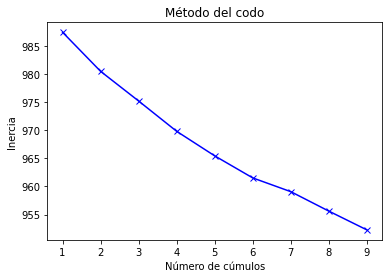

In [5]:
# Método del codo

plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title("Método del codo")
plt.plot(ks, k_inertias, 'bx-')

###  `[10 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [6]:
#Entrenamiento del modelo

k = 6
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)

KMeans(n_clusters=6)

In [7]:
datos['cluster'] = model.labels_
datos

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,cluster
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry,2
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games,4
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games,0
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games,3
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games,3
...,...,...,...,...,...,...,...,...,...
995,es_0427672,product_es_0899883,reviewer_es_0474735,2,En la foto parece que la cadena sea más gruesa...,Cadena muy fina,es,jewelry,3
996,es_0059540,product_es_0702564,reviewer_es_0754753,3,"Bien por su precio, la cadena demasiado fina.",E,es,jewelry,3
997,es_0303349,product_es_0678671,reviewer_es_0172313,5,Muy bien!! Ahora tengo organizados los pendien...,Bonito,es,jewelry,3
998,es_0659961,product_es_0294943,reviewer_es_0554554,4,"Las tapas para los joystics no están nada mal,...",No está mal pero sólo he probado las fundas.,es,video_games,0


###  `[15 pts]` Punto 4: Interpretación de los clusters

In [9]:
#los vecinos más cercanas al centroide
#entrenamiento con matriz tfif

nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

#porcentaje de los datos de cada clase

clust_cnt = datos['cluster'].value_counts()
clust_cnt_pct = datos['cluster'].value_counts(normalize=True)

centroids = model.cluster_centers_

terms = tfidf_vect.get_feature_names()
order_centroids = centroids.argsort()[:, ::-1]

for i in range(k):
    print(f"CLUSTER #{i}")
    print(f"Tiene {clust_cnt[i]} registros ({clust_cnt_pct[i]:.2%} de los datos)")
    
    print("Palabras más importantes: ")
    for ind in order_centroids[i][:10]:
        print(terms[ind], end=" ")
    print()
    
    print(f"Comentarios más Representativos: ")
    for vecino in datos.iloc[nbrs.kneighbors([centroids[i]])[1][0]].review_body.values:
        print(f" *{vecino}")
        
    print("********************************************")
    print()

CLUSTER #0
Tiene 535 registros (53.50% de los datos)
Palabras más importantes: 
perfecto bonito bonitos si foto calidad mas tiempo mando pulsera 
Comentarios más Representativos: 
 *Llegó a tiempo y en perfecto estado
 *Perfecto y en tiempo
 *Son muy bonitos pero tal vez un poco más grande de lo que me esperaba. El cierre es de calidad.
********************************************

CLUSTER #1
Tiene 59 registros (5.90% de los datos)
Palabras más importantes: 
regalo bonito encantó ve pequeño buen calidad igual gustado colgante 
Comentarios más Representativos: 
 *Esta bien,fue un regalo
 *Bonito fue para un regalo y bien
 *Fue para un regalo y le encantó
********************************************

CLUSTER #2
Tiene 74 registros (7.40% de los datos)
Palabras más importantes: 
calidad buena precio puede pedir relación mala compra bueno bien 
Comentarios más Representativos: 
 *Calidad precio muy buena
 *Calidad precio buena
 *Calidad precio buena
*****************************************

In [18]:
#Poner etiquetas o nombres a los clústers
clusters = {0: 'Totalmente satisfecho',
            1: 'Algo satisfecho',
            2: 'Satisfecho',
            3: 'Medianamente satisfecho',
            4: 'Algo Insatisfecho',
            5: 'Totalmente insatisfecho',
           }

datos['nombres_clusters'] = datos['cluster'].apply(lambda val: clusters[val])
datos.sample(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,cluster,nombres_clusters
21,es_0484807,product_es_0457272,reviewer_es_0337259,2,Lo compré junto con una pulsera que me salía s...,No compres la pulsera a juego,es,jewelry,0,Totalmente satisfecho
564,es_0564139,product_es_0983142,reviewer_es_0842147,3,"Esta bien pero no es como el minecraft normal,...",Es buen juego pero es aburrido,es,video_games,3,Medianamente satisfecho
79,es_0731387,product_es_0807074,reviewer_es_0039174,4,Son bonitos pero quizás la figura del cisne es...,Algo pequeño la figura,es,jewelry,3,Medianamente satisfecho
934,es_0116506,product_es_0293121,reviewer_es_0404360,1,El ala es muy grande..pero no es todo eso..oja...,Muy caro y tuve que tirarlo a la basura,es,jewelry,0,Totalmente satisfecho
474,es_0406102,product_es_0966051,reviewer_es_0968001,5,Ideal para lo que quiera tunear,Precioso,es,jewelry,0,Totalmente satisfecho


###  `[BONUS: 3 pts]` Visualización usando PCA

In [20]:
pca = PCA(n_components=2)
result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = datos.nombres_clusters.values
result['texto'] = datos.review_body.apply(lambda val: val[:140])

result.head()

,X,Y,cluster,texto
0,0.486518,-0.324922,Satisfecho,"Buen. Buena calidad, y buena presentación."
1,-0.106915,-0.150044,Algo Insatisfecho,"Un producto a perfecto, para salir de casa con..."
2,-0.071097,-0.030632,Totalmente satisfecho,No funciona con Nintendo Switch. No hay forma ...
3,0.031718,0.233557,Medianamente satisfecho,"Recomendado, los utilizo para pc y no me dan n..."
4,0.016491,0.094534,Medianamente satisfecho,El cable funciona bien podria ser un poco mas ...


In [28]:
#agregar colores

colorsIdx = {'Totalmente satisfecho': 'green', 'Algo satisfecho': 'yellowgreen', 'Satisfecho': 'blue',
             'Medianamente satisfecho': 'red', 'Algo Insatisfecho': 'orange', 'Totalmente insatisfecho': 'orangered'}

result['colores'] = (result['cluster'].map(colorsIdx))
result.head()

,X,Y,cluster,texto,colores
0,0.486518,-0.324922,Satisfecho,"Buen. Buena calidad, y buena presentación.",blue
1,-0.106915,-0.150044,Algo Insatisfecho,"Un producto a perfecto, para salir de casa con...",orange
2,-0.071097,-0.030632,Totalmente satisfecho,No funciona con Nintendo Switch. No hay forma ...,green
3,0.031718,0.233557,Medianamente satisfecho,"Recomendado, los utilizo para pc y no me dan n...",red
4,0.016491,0.094534,Medianamente satisfecho,El cable funciona bien podria ser un poco mas ...,red


In [29]:
#gráfica
trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['colores'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Comparación

### `[BONUS 15 pts (validos para cualquier tarea)]` 
### Hacer predicción para estas dos frases de los dos modelos (clasificación y $k$-means)

In [ ]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]

### `[5 pts]` Punto 5: Preguntas

- Según los resultados del $K$-Means, ¿cuál es la estructura de los datos?
- ¿Qué diferencia notó entre los resultados del taller pasado y este?
- ¿Alguna otra observación?